In [2]:
import time
import numpy as np
from matplotlib import pyplot
from matplotlib import pyplot as plt
import pickle
import pandas as pd

In [3]:
#data=pickle.load(open('processed_data.p', "rb" ))
data_list=['Barclays-Noida-3.2-Jan', 'Barclays-Noida-3.2-Feb', 'Barclays-Noida-3.2-March','Barclays-Noida-3.2-April']

for month in range(len(data_list)):
    month_data=pickle.load(open('processed_data/'+data_list[month]+'.p', "rb" ))
    if month==0:
        data=month_data.copy()
    else:
        data=pd.concat([data,month_data])

In [4]:
seat_data=data.loc[data['seatName']=='B5_9_1_05']
seat_data=seat_data.sort_values(['Datetime'])
#drop unecessary columns
seat_data=seat_data.drop(['Country','Location','Resource Type','floor','Department','seatName'],axis=1)
seat_data.set_index('Datetime',inplace=True)
seat_data['day_of_week']=seat_data.index.weekday_name
seat_data['hour']=seat_data.index.hour
seat_data['minute']=seat_data.index.minute

# encode values
columns_to_encode=['day_of_week','hour','minute']
seat_data= pd.get_dummies(seat_data, columns=columns_to_encode)
seat_data.head(3)
#seat_data.index.freq='10T'

,Space,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,hour_0,hour_1,...,hour_20,hour_21,hour_22,hour_23,minute_0,minute_10,minute_20,minute_30,minute_40,minute_50
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-29 00:00:00,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2018-01-29 00:10:00,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2018-01-29 00:20:00,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [5]:
# transform to supervised learning
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.dropna(inplace=True)
    return df

In [6]:
sv_seat_data = timeseries_to_supervised(seat_data['Space'], 1)
sv_seat_data.columns=['x',  'y']
sv_seat_data['x']=sv_seat_data['x'].astype('int64')
display(sv_seat_data.head(3))

,x,y
Datetime,,
2018-01-29 00:10:00,0,0
2018-01-29 00:20:00,0,0
2018-01-29 00:30:00,0,0


In [7]:
#df=sv_seat_data.merge(seat_data,how='inner',left_index=True,right_index=True)
df=pd.merge(sv_seat_data,seat_data, right_index=True, left_index=True,  how='left')
df.drop(['Space'],axis=1,inplace=True)
df.head(3)

,x,y,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,hour_0,...,hour_20,hour_21,hour_22,hour_23,minute_0,minute_10,minute_20,minute_30,minute_40,minute_50
Datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-29 00:10:00,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2018-01-29 00:20:00,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2018-01-29 00:30:00,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [15]:
date_split='2018-04-24'
train,test=df.iloc[df.index<date_split],df.iloc[df.index>=date_split]
y_train,x_train=train['y'],train.drop(['y'],axis=1)
y_test,x_test=test['y'],test.drop(['y'],axis=1)

In [16]:
from sklearn.metrics import r2_score,accuracy_score,classification_report,roc_auc_score,log_loss,zero_one_loss,confusion_matrix
def regression_metric(y_true,y_predict):
    return r2_score(y_true,y_predict)
def classification_metric(y_true,y_predict):
    print('accuracy score',accuracy_score(y_true,y_predict))
    print('roc_auc_score',roc_auc_score(y_true, y_predict))
    print('log loss score',log_loss(y_true,y_predict))
    print('zero_one_loss score',zero_one_loss(y_true,y_predict))
    print('confusion_matrix',confusion_matrix(y_true,y_predict))
    print(classification_report(y_true,y_predict))

In [21]:
def plot_results(train,test,y_hat):
    #plt.plot(train,label='Train')
    plt.plot(test,label='Test')
    plt.plot(y_hat,label='forecast')
    plt.legend(loc='best')
    plt.show();
def plot_specific_results(train,test,y_hat):
    plt.plot(test[300:600],label='Test')
    plt.plot(y_hat[300:600],label='forecast')
    plt.legend(loc='best')
    plt.show();

### Regression

In [18]:
import statsmodels.api as sm
X2 = sm.add_constant(x_train['x'])
est = sm.OLS(y_train, x_train['x'])
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                 2.092e+04
Date:                Mon, 14 May 2018   Prob (F-statistic):               0.00
Time:                        15:54:21   Log-Likelihood:                 155.45
No. Observations:               12671   AIC:                            -308.9
Df Residuals:                   12670   BIC:                            -301.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x              0.7894      0.005    144.627      0.0

In [19]:
from sklearn.linear_model import LinearRegression
regr=LinearRegression()
r_x_train=np.reshape(x_train['x'],(-1,1))
regr.fit(r_x_train,y_train)
pred=regr.predict(np.reshape(x_test['x'],(-1,1)))
regression_metric(y_test,pred)

C:\Users\ndrs\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


0.6562412251310312

In [23]:
print(x_test[:20])

                     x  day_of_week_Friday  day_of_week_Monday  \
Datetime                                                         
2018-04-24 00:00:00  1                   0                   0   
2018-04-24 00:10:00  1                   0                   0   
2018-04-24 00:20:00  1                   0                   0   
2018-04-24 00:30:00  1                   0                   0   
2018-04-24 00:40:00  0                   0                   0   
2018-04-24 00:50:00  0                   0                   0   
2018-04-24 01:00:00  0                   0                   0   
2018-04-24 01:10:00  0                   0                   0   
2018-04-24 01:20:00  0                   0                   0   
2018-04-24 01:30:00  0                   0                   0   
2018-04-24 01:40:00  0                   0                   0   
2018-04-24 01:50:00  0                   0                   0   
2018-04-24 02:00:00  0                   0                   0   
2018-04-24

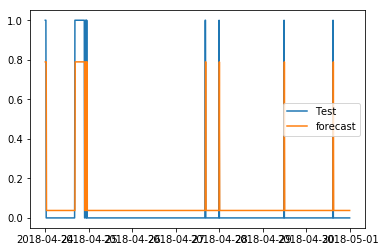

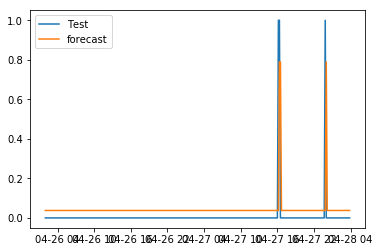

In [22]:
y_hat=test.copy()
y_hat['forecast']=pred

plot_results(train['y'],test['y'],y_hat['forecast'])
plot_specific_results(train['y'],test['y'],y_hat['forecast'])

### Classification

In [24]:
def feature_plot(imp_features,X):
    indices = np.argsort(imp_features)[::-1]
    num_features=len(imp_features[imp_features>0])
    columns = X.columns.values[indices][:num_features]
    values=imp_features[indices][:num_features]

    plt.figure(figsize = (15,5))
    plt.title("Feature importances")
    plt.barh(range(num_features), values, align="center")
    plt.yticks(range(num_features), columns)
    plt.ylim([ num_features,-1])
    plt.show() 

## With X variable

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier,BaggingClassifier,GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

DT_clf=DecisionTreeClassifier()
RF_clf=RandomForestClassifier()
SGD_clf=SGDClassifier()
MLP_clf=MLPClassifier()
AB_clf=AdaBoostClassifier()
KN_clf=KNeighborsClassifier()
GB_clf=GradientBoostingClassifier()
SVC_clf=SVC()
NB_clf=GaussianNB()
for clf in [DT_clf,RF_clf,SGD_clf,MLP_clf,AB_clf,KN_clf,GB_clf,SVC_clf,NB_clf]:
    print('classifier: ',clf.__class__.__name__)
    clf.fit(x_train,y_train)
    pred=clf.predict(x_test)
    classification_metric(y_test,pred)

classifier:  DecisionTreeClassifier
accuracy score 0.9751984126984127
roc_auc_score 0.8460486608826858
log loss score 0.8566259970654069
zero_one_loss score 0.024801587301587324
confusion_matrix [[952  12]
 [ 13  31]]
             precision    recall  f1-score   support

          0       0.99      0.99      0.99       964
          1       0.72      0.70      0.71        44

avg / total       0.97      0.98      0.98      1008

classifier:  RandomForestClassifier
accuracy score 0.9702380952380952
roc_auc_score 0.8326103357223688
log loss score 1.0279524656807584
zero_one_loss score 0.029761904761904767
confusion_matrix [[948  16]
 [ 14  30]]
             precision    recall  f1-score   support

          0       0.99      0.98      0.98       964
          1       0.65      0.68      0.67        44

avg / total       0.97      0.97      0.97      1008

classifier:  SGDClassifier


C:\Users\ndrs\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


accuracy score 0.9851190476190477
roc_auc_score 0.9163051678611844
log loss score 0.5139762328403796
zero_one_loss score 0.014880952380952328
confusion_matrix [[956   8]
 [  7  37]]
             precision    recall  f1-score   support

          0       0.99      0.99      0.99       964
          1       0.82      0.84      0.83        44

avg / total       0.99      0.99      0.99      1008

classifier:  MLPClassifier
accuracy score 0.9791666666666666
roc_auc_score 0.8698132780082988
log loss score 0.7195657740748286
zero_one_loss score 0.02083333333333337
confusion_matrix [[954  10]
 [ 11  33]]
             precision    recall  f1-score   support

          0       0.99      0.99      0.99       964
          1       0.77      0.75      0.76        44

avg / total       0.98      0.98      0.98      1008

classifier:  AdaBoostClassifier
accuracy score 0.9861111111111112
roc_auc_score 0.9168238400603546
log loss score 0.47971078046702564
zero_one_loss score 0.01388888888888884
confus

Models with the best results are:
1. AdaBoostClassifier
2. GradientBoostingClassifier
3. SVC

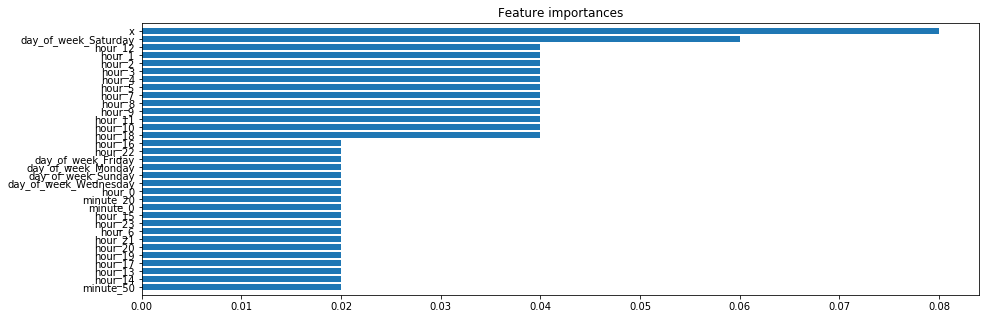

accuracy score 0.5704365079365079
roc_auc_score 0.76456997359487
log loss score 14.836940084410882
zero_one_loss score 0.4295634920634921
confusion_matrix [[532 432]
 [  1  43]]
             precision    recall  f1-score   support

          0       1.00      0.55      0.71       964
          1       0.09      0.98      0.17        44

avg / total       0.96      0.57      0.69      1008



In [26]:
clf=AdaBoostClassifier()
clf.fit(x_train,y_train)
imp_features=clf.feature_importances_
feature_plot(imp_features,x_test)
classification_metric(y_test,pred)

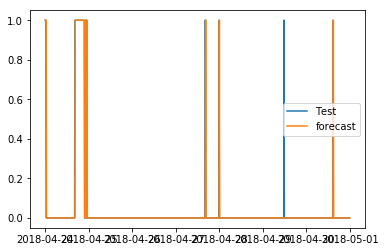

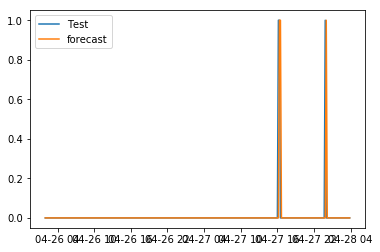

In [27]:
y_hat=test.copy()
pred=clf.predict(x_test)
y_hat['forecast']=pred

plot_results(train['y'],test['y'],y_hat['forecast'])
plot_specific_results(train['y'],test['y'],y_hat['forecast'])

### PART 2: WITHOUT X variable

In [28]:
x_train.drop(['x'],axis=1,inplace=True)
x_test.drop(['x'],axis=1,inplace=True)

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier,BaggingClassifier,GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

DT_clf=DecisionTreeClassifier()
RF_clf=RandomForestClassifier()
SGD_clf=SGDClassifier()
MLP_clf=MLPClassifier()
AB_clf=AdaBoostClassifier()
KN_clf=KNeighborsClassifier()
GB_clf=GradientBoostingClassifier()
SVC_clf=SVC()
NB_clf=GaussianNB()
for clf in [DT_clf,RF_clf,SGD_clf,MLP_clf,AB_clf,KN_clf,GB_clf,SVC_clf,NB_clf]:
    print('classifier: ',clf.__class__.__name__)
    clf.fit(x_train,y_train)
    pred=clf.predict(x_test)
    classification_metric(y_test,pred)

classifier:  DecisionTreeClassifier
accuracy score 0.8938492063492064
roc_auc_score 0.6625330064126744
log loss score 3.666382779411994
zero_one_loss score 0.1061507936507936
confusion_matrix [[883  81]
 [ 26  18]]
             precision    recall  f1-score   support

          0       0.97      0.92      0.94       964
          1       0.18      0.41      0.25        44

avg / total       0.94      0.89      0.91      1008

classifier:  RandomForestClassifier
accuracy score 0.8898809523809523
roc_auc_score 0.6713032817804603
log loss score 3.8034453821568284
zero_one_loss score 0.11011904761904767
confusion_matrix [[878  86]
 [ 25  19]]
             precision    recall  f1-score   support

          0       0.97      0.91      0.94       964
          1       0.18      0.43      0.26        44

avg / total       0.94      0.89      0.91      1008

classifier:  SGDClassifier
accuracy score 0.8541666666666666
roc_auc_score 0.7285458317615994
log loss score

C:\Users\ndrs\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


 5.0370072203575065
zero_one_loss score 0.14583333333333337
confusion_matrix [[835 129]
 [ 18  26]]
             precision    recall  f1-score   support

          0       0.98      0.87      0.92       964
          1       0.17      0.59      0.26        44

avg / total       0.94      0.85      0.89      1008

classifier:  MLPClassifier
accuracy score 0.8859126984126984
roc_auc_score 0.6258487363259148
log loss score 3.9405040186445683
zero_one_loss score 0.11408730158730163
confusion_matrix [[878  86]
 [ 29  15]]
             precision    recall  f1-score   support

          0       0.97      0.91      0.94       964
          1       0.15      0.34      0.21        44

avg / total       0.93      0.89      0.91      1008

classifier:  AdaBoostClassifier
accuracy score 0.9345238095238095
roc_auc_score 0.48858921161825725
log loss score 2.2614849535789388
zero_one_loss score 0.06547619047619047
confusion_matrix [[942  22]
 [ 44   0]]
             precision    recall  f1-score   sup

C:\Users\ndrs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Models with the best results are:
1. RandomForestClassifier
2. DecisionTreeClassifier
3. GradientBoostingClassifier

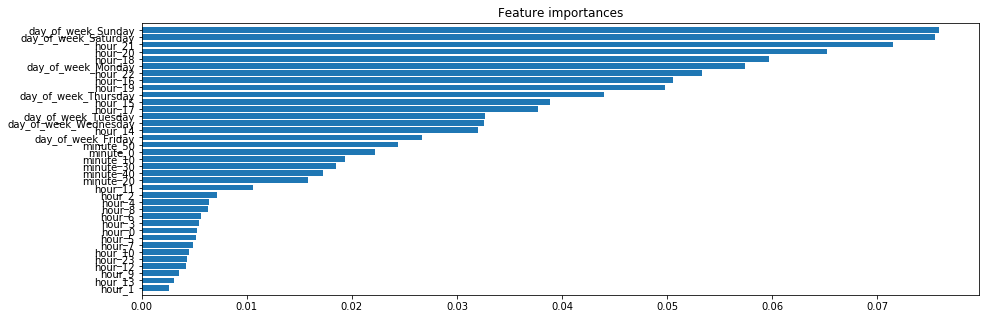

accuracy score 0.5416666666666666
roc_auc_score 0.7495284798189361
log loss score 15.830638203238149
zero_one_loss score 0.45833333333333337
confusion_matrix [[503 461]
 [  1  43]]
             precision    recall  f1-score   support

          0       1.00      0.52      0.69       964
          1       0.09      0.98      0.16        44

avg / total       0.96      0.54      0.66      1008



In [30]:
clf=RandomForestClassifier()
clf.fit(x_train,y_train)
imp_features=clf.feature_importances_
feature_plot(imp_features,x_test)
classification_metric(y_test,pred)

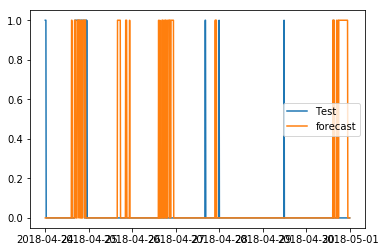

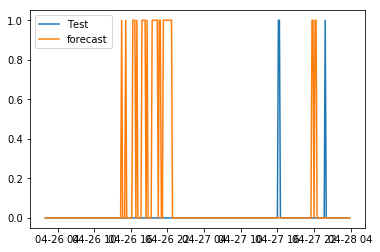

In [31]:
y_hat=test.copy()
pred=clf.predict(x_test)
y_hat['forecast']=pred

plot_results(train['y'],test['y'],y_hat['forecast'])
plot_specific_results(train['y'],test['y'],y_hat['forecast'])